In [5]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "0"

In [1]:
import sys
sys.path.append('../tools')

In [2]:
import timm
import pandas as pd
import numpy as np
# from tqdm.notebook import tqdm
from madgrad import MADGRAD
from fastai.vision.all import *
from train_utils import *
from fastai.callback.tensorboard import TensorBoardCallback

# from train_utils import *

In [3]:
# write_basic_config()

In [4]:

class CONF( ConfigClass):
    arcface_s = 30.0
    n_epoch = 20
    start_m = 0.5
    end_m = 1.0
    bs = 128
    size = 224
    split_nfnet=0
    embedding_size=1024
    experiment_id=1
    OUTPUT_CLASSES= 11014
    debug = False

conf = CONF()

In [5]:
# base_path = 'data'
base_path = '../data'
conv_layer = 'adaptconcat_lin'
saved_folder = base_path + '/saved_models/image_model/'
saved_name  = f'{conf.n_epoch}epoch_nfnetl0-bs-{conf.bs}-mgrad-{conv_layer}-embed-{conf.embedding_size}-m{(int(conf.start_m*10)):02d}-{int(conf.end_m)*10}'
image_path = base_path + '/train_images/'

In [6]:
class ArcFaceNet(nn.Module):
    def __init__(self, arch, embedding_size=512, classifier=None):
        super().__init__()
        self.body = create_body(arch, cut=-2)
        nf = num_features_model(nn.Sequential(*self.body.children()))      
        self.after_conv=nn.Sequential(
                AdaptiveConcatPool2d(),
                Flatten(),
                nn.Linear(nf*2,embedding_size),
                nn.BatchNorm1d(embedding_size)
            )       

        self.classifier = classifier if classifier is not None else None
    def forward(self, x):
        x = self.body(x)
        embeddings = self.after_conv(x)
        return self.classifier(embeddings)


In [7]:


train_df = add_splits(pd.read_csv(base_path + '/train.csv'))
valid_df = train_df[train_df.is_valid==True].copy()
train_df.is_valid=False
if conf.debug:
    train_df = train_df[train_df.split==0]
    train_df.is_valid=False
    # train_df = train_df[:conf.bs * 3]
    # valid_df = valid_df[:conf.bs * 3]

train_df= pd.concat([train_df, valid_df])
labels = train_df.label_group.unique()


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [8]:
len(labels)

11014

In [9]:
train_df.head()

,posting_id,image,image_phash,title,label_group,split,is_valid
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,0,False
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE",2937985045,3,False
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,2,False
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi,4093212188,4,False
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,4,False


In [10]:
# model.load_state_dict(torch.load( saved_folder +  saved_name))
# model.classifier = classifier

In [11]:

arch = timm.create_model("eca_nfnet_l0", pretrained = True)
classifier = ArcFaceClassifier(in_features=conf.embedding_size)
model = ArcFaceNet(arch = arch, embedding_size=conf.embedding_size, classifier=classifier)
dls = get_image_dls(train_df, 
                    path=image_path,
                    valid_col=train_df.columns.get_loc("is_valid"),
                    size= conf.size,
                    bs=conf.bs
                    )
loss_func = ArcFaceLossFlat(m=conf.start_m)
opt_func = partial(OptimWrapper, opt=MADGRAD)

if conf.split_nfnet:
    split_func= split_nfnet
else:
    split_func = split_2way


In [12]:
# arch = timm.create_model("eca_nfnet_l0", pretrained = True)
# classifier = ArcFaceClassifier(in_features=conf.embedding_size)
# model = ArcFaceNet(arch = arch, embedding_size=conf.embedding_size, classifier=classifier)

In [13]:
# learn.load('stage1-fine_tune_3epoch_nfnetl1-bs-64-pre-mgrad-gdconv-embed-1024-m03-10')

In [14]:
print('Starting', conf.experiment_id)
print(conf)


Starting 1
{'OUTPUT_CLASSES': 11014, 'arcface_s': 30.0, 'bs': 128, 'debug': False, 'embedding_size': 1024, 'end_m': 1.0, 'experiment_id': 1, 'n_epoch': 20, 'size': 224, 'split_nfnet': 0, 'start_m': 0.5}


In [15]:

learn = Learner(dls=dls,
                model=model,
                splitter=split_func, 
                opt_func=opt_func,
                loss_func=loss_func, 
                cbs = [ 
                        CutMix, 
                        GradientClip,
                        MixedPrecision, 
                        MarginScheduler(conf.start_m, conf.end_m),
                        SaveModelCallback(fname= saved_name,monitor='f1_score', comp=np.greater)
                    ],
                metrics=[accuracy, F1Score(average='weighted')]
                )

learn.add_cb(TensorBoardCallback(log_dir='../logs/eca_nfnetl0_epoch_10/', trace_model=False))


In [16]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,21.801853,16.809126,0.503940,0.515250,08:15


Better model found at epoch 0 with valid_loss value: 16.809125900268555.


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,17.523918,13.284971,0.780356,0.796668,08:22


Better model found at epoch 0 with valid_loss value: 13.284971237182617.


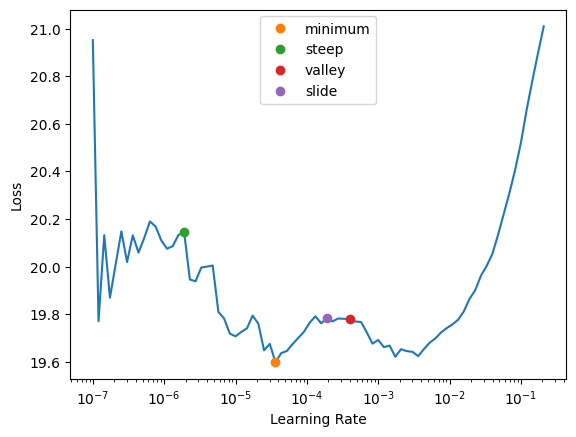

In [17]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [43]:
(lr_slide + lr_valley) /2

0.0002943266154034063

In [18]:
learn.save('stage0-'+ saved_name)

Path('../data/train_images/models/stage0-20epoch_nfnetl0-bs-128-mgrad-adaptconcat_lin-embed-1024-m05-10.pth')

In [44]:
learn.fine_tune(conf.n_epoch,base_lr=(lr_slide + lr_valley)/2)


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,17.155785,12.165695,0.816842,0.833978,06:51


Better model found at epoch 0 with f1_score value: 0.8339778683466477.


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,15.996820,11.667408,0.835668,0.852938,06:53
1,16.867126,11.850401,0.855517,0.872355,06:54
2,17.029314,11.865741,0.882370,0.898267,06:56
3,17.601189,11.794432,0.904408,0.918767,06:59
4,17.688427,11.624159,0.932720,0.944823,06:53
5,18.130724,11.497472,0.947023,0.957755,06:53
6,18.558437,11.529397,0.957531,0.965639,06:50
7,19.226942,11.627567,0.965120,0.972871,06:50
8,19.890215,11.821123,0.968914,0.975423,06:52
9,20.150923,12.029601,0.972417,0.978406,06:54


Better model found at epoch 0 with f1_score value: 0.8529376465620738.
Better model found at epoch 1 with f1_score value: 0.8723550731733906.
Better model found at epoch 2 with f1_score value: 0.8982665474849171.
Better model found at epoch 3 with f1_score value: 0.9187674967216707.
Better model found at epoch 4 with f1_score value: 0.9448226722352558.
Better model found at epoch 5 with f1_score value: 0.9577547359322356.
Better model found at epoch 6 with f1_score value: 0.9656388166620857.
Better model found at epoch 7 with f1_score value: 0.9728707817933516.
Better model found at epoch 8 with f1_score value: 0.975423273712154.
Better model found at epoch 9 with f1_score value: 0.978406003384088.
Better model found at epoch 10 with f1_score value: 0.9784310164205331.
Better model found at epoch 11 with f1_score value: 0.9793223201773767.
Better model found at epoch 12 with f1_score value: 0.9805393098515862.
Better model found at epoch 13 with f1_score value: 0.9811737115239455.
Bett

In [ ]:
# %debug

In [46]:
learn.save( 'stage1-'+ saved_name)

Path('../data/train_images/models/stage1-20epoch_nfnetl0-bs-128-mgrad-adaptconcat_lin-embed-1024-m05-10.pth')

In [47]:

print('saving',f'model' )
torch.save(learn.model.state_dict(), saved_folder +  saved_name + '_w_classifier.pth')
# save_without_classifier(learn.model, saved_folder +  saved_name + '_wo_classifier.pth')

saving model
